In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
!pip install pytorch-gradcam
from copy import deepcopy
from IPython.display import Audio
from module import models_lib
from module import config_lib, utils_lib

In [114]:

class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
            self.model_path = "/kaggle/input/bc25-models-fold0-mel-0411"
            
            self.device = "cpu"
            self.batch_size = 8
            self.n_jobs = 3
            
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.spectrogram_npy = '../data/processed/mel-spec_0329/birdclef2025_melspec_5sec_256_256.npy'
            self.MODELS_DIR = "../models/"
            self.model_path =  "../models/mel_cleaned0413/"
            
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
            self.batch_size = 32
            self.n_jobs = 3

        # ===== Model Settings =====
        self.model_name = 'efficientnet_b0'
        self.pretrained = True if mode == "train" else False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5
        self.TARGET_DURATION = 5
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 64
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        
        self.seed = 42
        


        # ===== Inference Mode =====
        if mode == "inference":
            self.use_tta = False
            self.tta_count = 3
            self.threshold = 0.5

            self.use_specific_folds = False
            self.folds = [0, 1, 2, 3, 4]  # Used only if use_specific_folds is True

            self.debug_count = 3
            
            
    def update_debug_settings(self):
        if self.debug:
            self.epochs = 2
            self.selected_folds = [0]
            
    
            
cfg = CFG(mode="inference", kaggle_notebook=False, debug=False)




In [115]:

utils_lib.set_seed(cfg.seed)

In [116]:
train_label = pd.read_csv(cfg.train_csv)
submission = pd.read_csv(cfg.submission_csv)
taxonomy = pd.read_csv(cfg.taxonomy_csv)

In [117]:
train_label.head()

primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   

   longitude        scientific_name            common_name             author  \
0   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
1   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
2   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
3   -73.8582  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
4   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   

           license  
0  cc-by-nc-sa 4.0  
1  cc-by-nc-sa 4.0  
2  cc-by-nc-sa 4.0  
3  cc-by-nc-sa 4.0  
4  cc-by-nc-sa 4.0

In [78]:
taxonomy.head()

primary_label  inat_taxon_id               scientific_name  \
0       1139490        1139490          Ragoniella pulchella   
1       1192948        1192948         Oxyprora surinamensis   
2       1194042        1194042           Copiphora colombiae   
3        126247         126247       Leptodactylus insularum   
4       1346504        1346504  Neoconocephalus brachypterus   

                    common_name class_name  
0          Ragoniella pulchella    Insecta  
1         Oxyprora surinamensis    Insecta  
2           Copiphora colombiae    Insecta  
3        Spotted Foam-nest Frog   Amphibia  
4  Neoconocephalus brachypterus    Insecta

In [9]:

models = models_lib.load_models(cfg, 206)
model = models[0]

Found a total of 5 model files.
Loading model: ../models/mel_cleaned0413/model_fold0.pth


/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:215: UserWarning: 
NVIDIA H100 PCIe with CUDA capability sm_90 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_60 sm_70 sm_75 compute_70 compute_75.
If you want to use the NVIDIA H100 PCIe GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


Loading model: ../models/mel_cleaned0413/model_fold1.pth
Loading model: ../models/mel_cleaned0413/model_fold2.pth
Loading model: ../models/mel_cleaned0413/model_fold3.pth
Loading model: ../models/mel_cleaned0413/model_fold4.pth


In [95]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from gradcam import GradCAM
from gradcam.utils import visualize_cam
from torchvision import transforms

# === 1. Mel„Çπ„Éö„ÇØ„Éà„É≠„Ç∞„É©„É†ÁîªÂÉè„ÇíTensor„Å´Â§âÊèõ ===
def prepare_input_from_melspec(mel_numpy):
    mel_norm = (mel_numpy - mel_numpy.min()) / (mel_numpy.max() - mel_numpy.min() + 1e-6)
    mel_tensor = torch.tensor(mel_norm).unsqueeze(0).unsqueeze(0).float()  # shape: (1, 1, H, W)
    return mel_tensor

# === Conv2d„É¢„Ç∏„É•„Éº„É´Ôºà„Ç™„Éñ„Ç∏„Çß„ÇØ„ÉàÔºâ„ÇíËøî„Åô„Éê„Éº„Ç∏„Éß„É≥ ===
def get_last_conv_layer(model):
    for module in reversed(list(model.modules())):
        if isinstance(module, torch.nn.Conv2d):
            return module
    raise ValueError("Conv2d Â±§„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì")



def show_gradcam(model, mel_numpy, target_class, title="Grad-CAM"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    input_tensor = prepare_input_from_melspec(mel_numpy).to(device)

    target_layer = get_last_conv_layer(model)

    cam = GradCAM(model, target_layer)
    mask, _ = cam(input_tensor, target_class)

    # ÂèØË¶ñÂåñ
    heatmap, result = visualize_cam(mask, input_tensor[0])
    heatmap = np.transpose(heatmap, (1, 2, 0))  # (H, W, C)
    result = np.transpose(result, (1, 2, 0))

    # === ‰∏ä‰∏ã„ÇíÊ≠£„Åó„ÅèË°®Á§∫„Åô„Çã„Åü„ÇÅ„Å´‰∏ä‰∏ãÂèçËª¢ ===
    heatmap = np.flipud(heatmap)
    result = np.flipud(result)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(heatmap)
    plt.title("CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [96]:
spec = np.load("../data/processed/mel_cleaned_0413/birdclef2025_melspec_5sec_256_256.npy", allow_pickle=True).item()
working_df = pd.read_csv("../data/processed/mel_cleaned_0413/train.csv")

In [97]:
df = working_df[(working_df["rating"] == 5.0) & (working_df["duration_sec"] < 10)]
df.head()

primary_label secondary_labels                    type  \
231         22976             ['']  ['advertisement call']   
297         41663             ['']                ['call']   
508        517119             ['']  ['advertisement call']   
709         65373             ['']  ['advertisement call']   
921       amakin1             ['']                ['song']   

                 filename collection  rating                            url  \
231    22976/XC893972.ogg         XC     5.0  https://xeno-canto.org/893972   
297    41663/XC697007.ogg         XC     5.0  https://xeno-canto.org/697007   
508   517119/XC893992.ogg         XC     5.0  https://xeno-canto.org/893992   
709    65373/XC941284.ogg         XC     5.0  https://xeno-canto.org/941284   
921  amakin1/XC128804.ogg         XC     5.0  https://xeno-canto.org/128804   

     latitude  longitude              scientific_name  ...        samplename  \
231   20.4215   -88.4714       Leptodactylus fragilis  ...    22976-XC893972   
297   49.1523     2.3752                Procyon lotor  ...    41663-XC697007   
508   10.9747   -84.7441          Rhinella horribilis  ...   517119-XC893992   
709    9.0443   -79.3026  Dendropsophus microcephalus  ...    65373-XC941284   
921  -16.7581   -56.8764         Chloroceryle amazona  ...  amakin1-XC128804   

        class crop_strategy  duration_sec valid_start_sec valid_end_sec  \
231  Amphibia        center      7.488000               0      7.488000   
297  Mammalia        center      7.105000               0      7.105000   
508  Amphibia        center      6.164906               0      6.164906   
709  Amphibia        center      7.720313               0      7.720313   
921      Aves        center      9.816000               0      9.816000   

    n_augment multi_crop          group_id  fold  
231         0      False    22976-XC893972     2  
297         0      False    41663-XC697007     4  
508         0      False   517119-XC893992     4  
709         0      False    65373-XC941284     4  
921         0      False  amakin1-XC128804     1  

[5 rows x 25 columns]

In [98]:
i = 1
filename=df["filename"].iloc[i]
utils_lib.play_audio(filename, cfg.train_datadir)

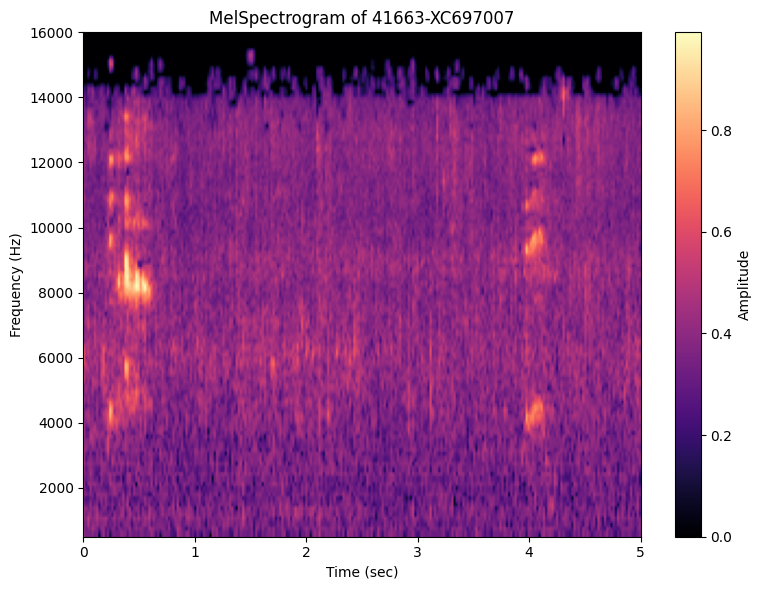

In [91]:
# Ë°®Á§∫„Åó„Åü„ÅÑ species_id „ÇíÊåáÂÆöÔºà‰æã: 'pitangsp'Ôºâ
samplename= df["samplename"].iloc[i] 
species_id = samplename # ÂÆüÈöõ„ÅÆID„Å´ÁΩÆ„ÅçÊèõ„Åà„Å¶„Åè„Å†„Åï„ÅÑ

# Mel„Çπ„Éö„ÇØ„Éà„É≠„Ç∞„É©„É†„ÇíÂèñÂæó
mel = spec[species_id]  # shape: (256, 256)

n_mels = 148  # ‰æã: 256
fmin = 500           # ÂÆüÈöõ„Å´‰ΩøÁî®„Åó„Åüfmin
fmax = 16000           # ÂÆüÈöõ„Å´‰ΩøÁî®„Åó„Åüfmax
duration = 5.0         # „É°„É´„Çπ„Éö„ÇØ„Éà„É≠„Ç∞„É©„É†„ÅÆÊôÇÈñìÔºàÁßíÔºâ

# XËª∏ÔºàÊôÇÈñìÔºâ„Å® YËª∏ÔºàÂë®Ê≥¢Êï∞Ôºâ„ÅÆÁØÑÂõ≤ÊåáÂÆö
extent = [0, duration, fmin, fmax]  # [x_min, x_max, y_min, y_max]

# Ë°®Á§∫
plt.figure(figsize=(8, 6))
plt.imshow(mel, aspect='auto', origin='lower', cmap='magma', extent=extent)
plt.title(f"MelSpectrogram of {species_id}")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()

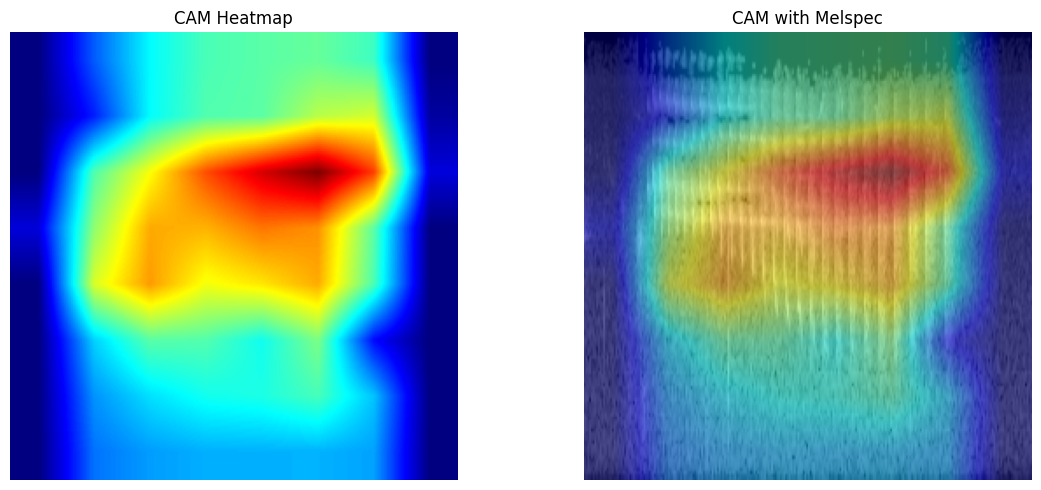

target_class: 60
samplename: amakin1-XC939547


In [ ]:
mel = spec[samplename]  # Mel„Çπ„Éö„ÇØ„Éà„É≠„Ç∞„É©„É†ÔºàNumPyÂΩ¢ÂºèÔºâ
model = models[0]  # „ÅÇ„Å™„Åü„ÅÆ„É¢„Éá„É´
target_class = df["target"].iloc[i]  # ‰æãÔºöÊ≥®ÁõÆ„Åô„Çãspecies„ÅÆclass index

show_gradcam(model, mel, target_class, title="CAM with Melspec")
print("target_class:", target_class)
print("samplename:", samplename)

In [108]:
import matplotlib.pyplot as plt
import librosa.display

# ---- „Éë„É©„É°„Éº„ÇøÔºàMelSpecÁîüÊàê„Å®‰∏ÄËá¥„Åï„Åõ„Å¶„Åè„Å†„Åï„ÅÑÔºâ ----
fmin = 50
fmax = 16000
sr = 32000
hop_length = 16  # MelÁîüÊàê„Å´‰Ωø„Å£„ÅüÂÄ§
duration_sec = 5  # MelSpec 1Êûö„ÅÇ„Åü„Çä„ÅÆÈï∑„ÅïÔºàÁßíÔºâ
n_mels = 148      # ÂÆüÈöõ„ÅÆMelSpec„ÅÆÁ∏¶„Çµ„Ç§„Ç∫
class_name = "Mammalia"  # ÊäΩÂá∫„Åó„Åü„ÅÑ„ÇØ„É©„ÇπÂêçÔºà‰æã: "Mammalia"Ôºâ
# ---- Amphibia„ÇØ„É©„Çπ„Å†„ÅëÊäΩÂá∫ ----
class_df = working_df[working_df["class"] == class_name]

# ---- ÂêÑ„É©„Éô„É´„Åî„Å®„Å´ rating „ÅÆÈ´ò„ÅÑ‰ª£Ë°®„Çí1‰ª∂ÊäΩÂá∫ ----
top_samples = (
    class_df.sort_values("rating", ascending=False)
    .groupby("primary_label")
    .first()
    .reset_index()  # ‚Üê „Åì„Çå„Åß primary_label „ÅåÂàó„Å´Êàª„Çã
)


In [109]:


def show_mel_and_play(samplename, working_df, spec, cfg):
    # --- „É°„ÇøÊÉÖÂ†±ÂèñÂæó ---
    row = working_df[working_df["samplename"] == samplename].iloc[0]
    mel = spec[samplename]
    filename = row["filename"]
    scientific_name = row.get("scientific_name", samplename)

    # --- MelË°®Á§∫Ë®≠ÂÆö ---
    fmin = cfg.FMIN
    fmax = cfg.FMAX
    duration = cfg.TARGET_DURATION
    extent = [0, duration, fmin, fmax]

    # --- ÊèèÁîª + Èü≥Â£∞ÂÜçÁîü ---
    plt.figure(figsize=(8, 4))
    plt.imshow(mel, aspect='auto', origin='lower', cmap='magma', extent=extent)
    plt.title(f"{scientific_name} ({samplename})")
    plt.xlabel("Time (sec)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Normalized Amplitude")
    plt.tight_layout()
    plt.show()
    
    print(f"filename: {filename}")

    # --- Èü≥Â£∞ÂÜçÁîü ---
    print("üîä ÂÜçÁîü‰∏≠...")
    display(utils_lib.play_audio(filename, cfg.train_datadir))


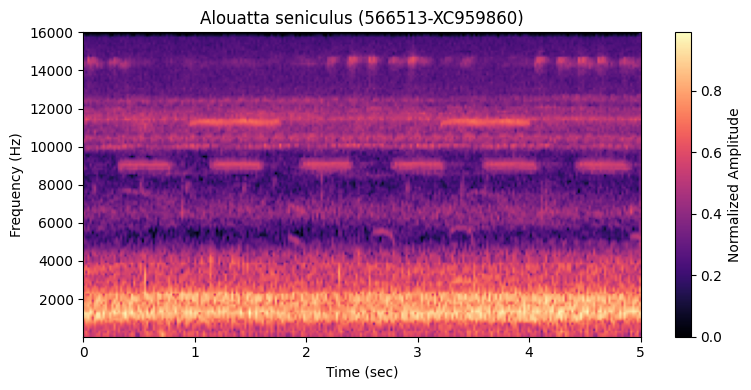

filename: 566513/XC959860.ogg
üîä ÂÜçÁîü‰∏≠...


In [135]:
i = 8
samplename=top_samples["samplename"][i]
show_mel_and_play(samplename, working_df, spec, cfg)

In [ ]:
# Mammalia Èü≥Ê∫ê„Å®mel„ÉÅ„Çß„ÉÉ„ÇØ 
# 41663/XC697007.ogg È´ò„ÅÑ „Ç≠„Ç≠„Å£„ÄÄ3k‰ª•‰∏ä
# 41778/XC959831.ogg È´ò„ÅÑÔºü„Éî„ÉºÔºé‰Ωé„ÅÑ„É°„ÉºÔºü 9k‰ª•‰∏äÔºü
# 41970/XC564867.ogg „Ç∏„É£„Ç¨„Éº„ÄÄ‰Ωé„ÅÑ„Ç¶„Éº Âë®Ê≥¢Êï∞Ë≠òÂà•‰∏çÂèØÔºé„Éé„Ç§„Ç∫Â§ö„Åô„ÅéÔºü
# 42007/iNat106462.ogg ‰Ωé„ÅÑÔºé„Ç∑„É£„Ç™„Éº 1k‰ª•‰∏ä
# 42087/iNat155127.ogg „ÇÆ„É£„Ç™„ÉºÔºé1k‰ª•‰∏ä
# 42113/iNat55456.ogg „Ç§„Éé„Ç∑„Ç∑Ôºé„ÄÄÂë®Ê≥¢Êï∞Ë≠òÂà•‰∏çÂèØ
# 46010/XC961102.ogg È´ò„ÅÑ 1k‰ª•‰∏ä
# 47067/iNat68676.ogg È´ò„ÅÑ„Éî„É•„Éº
# 566513/XC959860.ogg „Çè„Åã„Çâ„Å™„ÅÑ ‰Ωé„ÅÑ„Å®„Åç„ÇÇ„ÅÇ„Çã„Åã„ÇÇÔºü



In [ ]:
# Amphibia Èü≥Ê∫ê„Å®mel„ÉÅ„Çß„ÉÉ„ÇØ  ÂÖ®ÈÉ®„Åß„ÅØ„Å™„ÅÑ
# 126247/XC941297.ogg 1k‰ª•‰∏ä
# 134933/XC941298.ogg È´òÂë®Ê≥¢Ôºü„ÄÄmel„ÅßÁ¢∫Ë™ç„Åß„Åç„Å™„ÅÑ
# 135045/iNat1207347.ogg 8k‰ª•‰∏ä
# 21038/iNat65519.ogg 6K‰ª•‰∏ä  
# 21116/iNat65520.ogg „ÇÆ„Éº‰ΩéÂë®Ê≥¢„ÄÄÁ¢∫Ë™ç‰∏çÂèØ
# 21211/XC934741.ogg È´ò„ÅÑÔºé6K‰ª•‰∏ä
# 22333/XC890507.ogg„ÄÄÈ´ò„ÅÑ 5K‰ª•‰∏ä
# 22973/XC892927.ogg È´ò„ÅÑ 3K‰ª•‰∏ä
# 22976/XC893971.ogg È´ò„ÅÑ 3k‰ª•‰∏ä
# 24272/XC893991.ogg ‰Ωé„ÅÑ 1.5K‰ª•‰∏ä
# 24292/CSA34651.ogg ‰Ωé„ÅÑ 2K‰ª•‰∏ä
# 24322/XC915926.ogg„ÄÄ‰Ωé„ÅÑ 1.5k‰ª•‰∏ä
# 476537/CSA35461.ogg È´ò„ÅÑ„ÄÄ„Éï„Éº„É≥„Åø„Åü„ÅÑ„Å™Â£∞ 9k‰ª•‰∏ä
# 476538/XC926710.ogg ‰Ωé„ÅÑÔºü„ÄÄ„Ç≤„Ç≥„ÉÉÔºü 1k‰ª•‰∏ä
# 517119/XC893994.ogg ‰Ωé„ÅÑ„ÄÄ„Ç≤„Ç≥„Ç≥ 1k‰ª•‰∏ä
# 555086/XC892928.ogg È´ò„ÅÑ 1k‰ª•‰∏ä
# 555142/iNat761666.ogg ‰Ωé„ÅÑ 1k‰ª•‰∏ä



In [131]:
working_df[working_df["primary_label"] == "566513"]

primary_label secondary_labels                  type  \
641        566513             ['']  ['territorial call']   
642        566513             ['']                  ['']   
643        566513             ['']                  ['']   
644        566513             ['']                  ['']   
645        566513             ['']                  ['']   
646        566513             ['']                  ['']   
647        566513             ['']                  ['']   
648        566513             ['']                  ['']   
649        566513             ['']                  ['']   
650        566513             ['']                  ['']   
651        566513             ['']                  ['']   
652        566513             ['']                  ['']   
653        566513             ['']                  ['']   
654        566513             ['']                  ['']   
655        566513             ['']                  ['']   
656        566513             ['']                  ['']   
657        566513             ['']                  ['']   
658        566513             ['']                  ['']   
659        566513             ['']                  ['']   
660        566513             ['']                  ['']   
661        566513             ['']                  ['']   
662        566513             ['']                  ['']   
663        566513             ['']                  ['']   

                   filename collection  rating  \
641     566513/XC959860.ogg         XC     4.0   
642  566513/iNat1259526.ogg       iNat     0.0   
643   566513/iNat208383.ogg       iNat     0.0   
644   566513/iNat327841.ogg       iNat     0.0   
645   566513/iNat469763.ogg       iNat     0.0   
646   566513/iNat475442.ogg       iNat     0.0   
647   566513/iNat561526.ogg       iNat     0.0   
648   566513/iNat565106.ogg       iNat     0.0   
649   566513/iNat569946.ogg       iNat     0.0   
650    566513/iNat60494.ogg       iNat     0.0   
651    566513/iNat68561.ogg       iNat     0.0   
652    566513/iNat72467.ogg       iNat     0.0   
653    566513/iNat72468.ogg       iNat     0.0   
654   566513/iNat796863.ogg       iNat     0.0   
655   566513/iNat832952.ogg       iNat     0.0   
656   566513/iNat860046.ogg       iNat     0.0   
657   566513/iNat865113.ogg       iNat     0.0   
658   566513/iNat865114.ogg       iNat     0.0   
659   566513/iNat879932.ogg       iNat     0.0   
660   566513/iNat885527.ogg       iNat     0.0   
661   566513/iNat887872.ogg       iNat     0.0   
662   566513/iNat906866.ogg       iNat     0.0   
663   566513/iNat942150.ogg       iNat     0.0   

                                                   url  latitude  longitude  \
641                      https://xeno-canto.org/959860   -9.4462   -70.4362   
642  https://static.inaturalist.org/sounds/1259526.m4a   -4.2980   -73.2821   
643   https://static.inaturalist.org/sounds/208383.m4a    4.8430   -75.8186   
644   https://static.inaturalist.org/sounds/327841.m4a    8.8151   -76.4275   
645   https://static.inaturalist.org/sounds/469763.m4a   -0.2054   -75.9253   
646   https://static.inaturalist.org/sounds/475442.m4a   11.2712   -73.8442   
647   https://static.inaturalist.org/sounds/561526.m4a   11.2773   -73.9231   
648   https://static.inaturalist.org/sounds/565106.wav   11.2171   -73.4737   
649   https://static.inaturalist.org/sounds/569946.mp3   -0.6370   -76.1502   
650    https://static.inaturalist.org/sounds/60494.wav    4.7416   -75.5971   
651    https://static.inaturalist.org/sounds/68561.mp3    6.9674   -75.0535   
652    https://static.inaturalist.org/sounds/72467.mp3    4.8434   -75.8183   
653    https://static.inaturalist.org/sounds/72468.mp3    4.8434   -75.8183   
654   https://static.inaturalist.org/sounds/796863.wav   10.8794   -68.4098   
655   https://static.inaturalist.org/sounds/832952.wav   10.8794   -68.4098   
656   https://static.inaturalist.org/sounds/860046.m4a   11.1006   -74.0721   
657   https://stati

In [60]:
top_samples.shape

(34, 25)

In [133]:
utils_lib.play_audio("566513/iNat475442.ogg", cfg.train_datadir)